In [ ]:
import time
import asyncio
import numpy as np
from collections import deque
from dataclasses import dataclass
from typing import List, AsyncIterator
from enum import Enum
import matplotlib.pyplot as plt

@dataclass
class LatencyMetrics:
    audio_chunk_received: float = 0.0
    asr_started: float = 0.0
    asr_partial: float = 0.0
    asr_complete: float = 0.0
    llm_started: float = 0.0
    llm_first_token: float = 0.0
    llm_complete: float = 0.0
    tts_started: float = 0.0
    tts_first_chunk: float = 0.0
    tts_complete: float = 0.0

    def get_time_to_first_audio(self) -> float:
        return self.tts_first_chunk - self.asr_complete if self.tts_first_chunk and self.asr_complete else 0.0

    def get_total_latency(self) -> float:
        return self.tts_complete - self.audio_chunk_received if self.tts_complete else 0.0

@dataclass
class LatencyBudgets:
    asr_processing: float = 0.1
    asr_finalization: float = 0.3
    llm_first_token: float = 0.5
    llm_token_generation: float = 0.02
    tts_first_chunk: float = 0.2
    tts_chunk_generation: float = 0.05
    time_to_first_audio: float = 1.0

class AgentState(Enum):
    LISTENING = "listening"
    PROCESSING_SPEECH = "processing_speech"
    THINKING = "thinking"
    SPEAKING = "speaking"
    INTERRUPTED = "interrupted"

In [ ]:
class AudioInputStream:
    def __init__(self, sample_rate: int = 16000, chunk_duration_ms: int = 100):
        self.sample_rate = sample_rate
        self.chunk_duration_ms = chunk_duration_ms
        self.chunk_size = int(sample_rate * chunk_duration_ms / 1000)

    async def stream_audio(self, text: str) -> AsyncIterator[np.ndarray]:
        chars_per_second = (150 * 5) / 60
        duration_seconds = len(text) / chars_per_second
        num_chunks = int(duration_seconds * 1000 / self.chunk_duration_ms)

        for _ in range(num_chunks):
            chunk = np.random.randn(self.chunk_size).astype(np.float32) * 0.1
            await asyncio.sleep(self.chunk_duration_ms / 1000)
            yield chunk

In [ ]:
class StreamingASR:
    def __init__(self, latency_budget: float = 0.1):
        self.latency_budget = latency_budget
        self.silence_threshold = 0.5

    async def transcribe_stream(
        self,
        audio_stream: AsyncIterator[np.ndarray],
        ground_truth: str
    ) -> AsyncIterator[tuple[str, bool]]:
        words = ground_truth.split()
        words_transcribed = 0
        silence_duration = 0.0
        chunk_count = 0

        async for chunk in audio_stream:
            chunk_count += 1
            await asyncio.sleep(self.latency_budget)

            if chunk_count % 3 == 0 and words_transcribed < len(words):
                words_transcribed += 1
                yield " ".join(words[:words_transcribed]), False

            audio_power = np.mean(np.abs(chunk))
            silence_duration = silence_duration + 0.1 if audio_power < 0.05 else 0.0

            if silence_duration >= self.silence_threshold:
                await asyncio.sleep(0.2)
                yield ground_truth, True
                return

        yield ground_truth, True

In [ ]:
class StreamingLLM:
    def __init__(self, time_to_first_token: float = 0.3, tokens_per_second: float = 50):
        self.time_to_first_token = time_to_first_token
        self.tokens_per_second = tokens_per_second

    async def generate_response(self, prompt: str) -> AsyncIterator[str]:
        responses = {
            "hello": "Hello! How can I help you today?",
            "weather": "The weather is sunny with a temperature of 72°F.",
            "time": "The current time is 2:30 PM.",
            "default": "I understand. Let me help you with that."
        }

        response = responses["default"]
        for key in responses:
            if key in prompt.lower():
                response = responses[key]
                break

        await asyncio.sleep(self.time_to_first_token)

        for word in response.split():
            yield word + " "
            await asyncio.sleep(1.0 / self.tokens_per_second)

class StreamingTTS:
    def __init__(self, time_to_first_chunk: float = 0.2, chars_per_second: float = 15):
        self.time_to_first_chunk = time_to_first_chunk
        self.chars_per_second = chars_per_second

    async def synthesize_stream(self, text_stream: AsyncIterator[str]) -> AsyncIterator[np.ndarray]:
        first_chunk = True
        buffer = ""

        async for text in text_stream:
            buffer += text
            if len(buffer) >= 20 or first_chunk:
                if first_chunk:
                    await asyncio.sleep(self.time_to_first_chunk)
                    first_chunk = False

                duration = len(buffer) / self.chars_per_second
                yield np.random.randn(int(16000 * duration)).astype(np.float32) * 0.1
                buffer = ""
                await asyncio.sleep(duration * 0.5)

In [ ]:
class StreamingVoiceAgent:
    def __init__(self, latency_budgets: LatencyBudgets):
        self.budgets = latency_budgets
        self.audio_stream = AudioInputStream()
        self.asr = StreamingASR(latency_budgets.asr_processing)
        self.llm = StreamingLLM(
            latency_budgets.llm_first_token,
            1.0 / latency_budgets.llm_token_generation
        )
        self.tts = StreamingTTS(
            latency_budgets.tts_first_chunk,
            1.0 / latency_budgets.tts_chunk_generation
        )
        self.state = AgentState.LISTENING
        self.metrics_history: List[LatencyMetrics] = []

    async def process_turn(self, user_input: str) -> LatencyMetrics:
        metrics = LatencyMetrics()
        start_time = time.time()

        metrics.audio_chunk_received = time.time() - start_time
        audio_gen = self.audio_stream.stream_audio(user_input)

        metrics.asr_started = time.time() - start_time
        async for text, final in self.asr.transcribe_stream(audio_gen, user_input):
            if final:
                metrics.asr_complete = time.time() - start_time
                transcription = text

        metrics.llm_started = time.time() - start_time
        response = ""
        async for token in self.llm.generate_response(transcription):
            if not metrics.llm_first_token:
                metrics.llm_first_token = time.time() - start_time
            response += token

        metrics.llm_complete = time.time() - start_time
        metrics.tts_started = time.time() - start_time

        async def text_stream():
            for word in response.split():
                yield word + " "

        async for _ in self.tts.synthesize_stream(text_stream()):
            if not metrics.tts_first_chunk:
                metrics.tts_first_chunk = time.time() - start_time

        metrics.tts_complete = time.time() - start_time
        self.metrics_history.append(metrics)
        return metrics


    ╔══════════════════════════════════════════════════════════════════╗
    ║  Streaming Voice Agent with Latency Budgets - Tutorial Demo     ║
    ╚══════════════════════════════════════════════════════════════════╝
    
    This demo simulates a complete voice agent pipeline:
    
    1. 🎤 Audio Input:  Chunked audio streaming
    2. 📝 ASR:          Partial → Final transcription
    3. 🤖 LLM:          Streaming token generation
    4. 🔊 TTS:          Chunked audio synthesis
    
    Key Metrics:
    - TTFT: Time to First Token (LLM responsiveness)
    - TTFA: Time to First Audio (critical UX metric)
    - Total Latency: End-to-end pipeline time
    

👤 User: Hello, how are you today?

🎤 Simulating 2.0s of speech in 20 chunks
📝 ASR (partial 1): Hello,
📝 ASR (partial 2): Hello, how
📝 ASR (partial 3): Hello, how are
📝 ASR (partial 4): Hello, how are you
📝 ASR (partial 5): Hello, how are you today?
🤖 Assistant: 
   ⏱️  Time to first token: 0.302s
🤖 Assistant: I understand. Let me help 

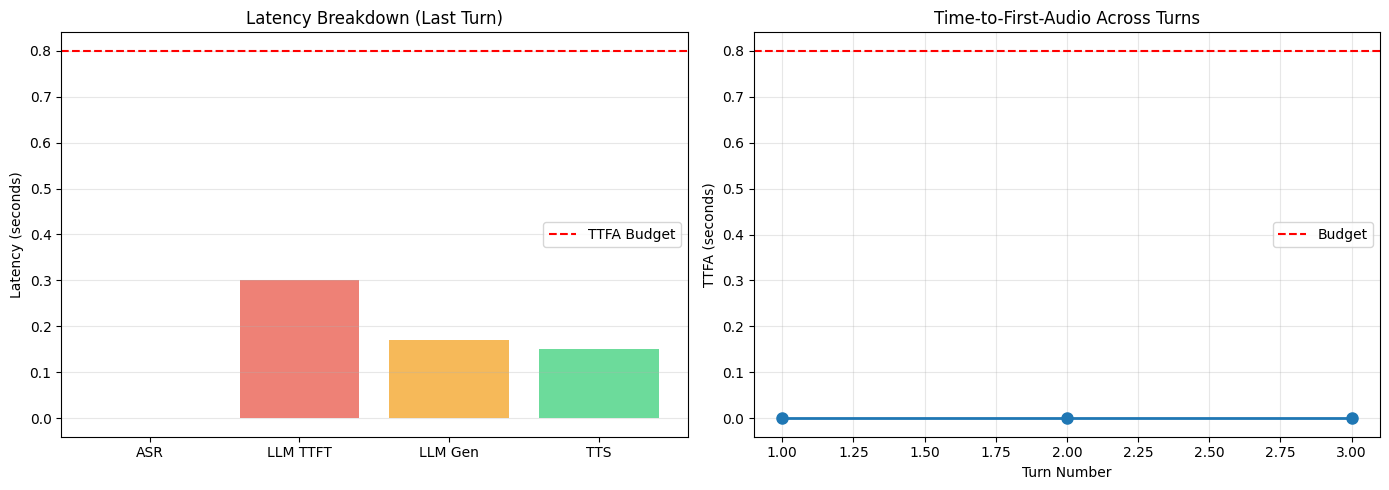


    ╔══════════════════════════════════════════════════════════════════╗
    ║  Optimization Tips for Low-Latency Voice Agents                  ║
    ╚══════════════════════════════════════════════════════════════════╝
    
    1. ASR Optimization:
       - Use streaming models (Whisper streaming, Deepgram)
       - Reduce chunk size for lower latency (trade-off: accuracy)
       - Implement voice activity detection (VAD)
    
    2. LLM Optimization:
       - Use smaller, faster models (e.g., Llama 3.1 8B)
       - Implement speculative decoding
       - Use prompt caching for system prompts
       - Consider distilled models
    
    3. TTS Optimization:
       - Use streaming TTS (Cartesia, ElevenLabs streaming)
       - Start synthesis before LLM completes
       - Buffer optimization for smooth playback
    
    4. Turn-Taking:
       - Implement end-of-turn detection
       - Allow interruptions (barge-in)
       - Use duplexing for natural conversation
    
    5. Infrastructur

In [2]:
async def run_demo():
    budgets = LatencyBudgets(
        asr_processing=0.08,
        llm_first_token=0.3,
        llm_token_generation=0.02,
        tts_first_chunk=0.15,
        time_to_first_audio=0.8
    )

    agent = StreamingVoiceAgent(budgets)

    inputs = [
        "Hello, how are you today?",
        "What's the weather like?",
        "Can you tell me the time?"
    ]

    for text in inputs:
        await agent.process_turn(text)
        await asyncio.sleep(1)

if __name__ == "__main__":
    asyncio.run(run_demo())